Notebook for training a 3D U-Net for vestibular schwannoma segmentation.

In [ ]:


# This cell is for Colab runs

!pip install tensorflow==2.10.1  # same version of tf used in local testing, Colab default (2.13) gives import errors with segmentation models library

!pip install segmentation_models_3D



     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.1/578.1 MB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 54.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 4.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 53.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 48.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 69.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 34.1 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 2.13.1
    Uninstalling keras-2.13.1:
      Successfully uninstalled keras-2.13.1
  Attempting uninstall: tensorflow-estimator
    Found existing installation: tensorflow-estimator 2.13.0
    Uninstalling tensorflow-estimator-2.13.0:
      Successfully uninstalled tensorflow-estimator-2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.7/50.7 kB 2.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 4.8 MB/s eta 0:00:00


In [ ]:


from google.colab import drive
drive.mount('/content/drive')



Mounted at /content/drive


In [ ]:
import sys
sys.path.append('/content/drive/MyDrive')

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
import tensorflow as tf
import segmentation_models_3D as sm
import att_res_unet

In [ ]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))

Num GPUs Available:  1


In [ ]:
IMG_WIDTH = 64
IMG_HEIGHT = 64
IMG_DEPTH = 64
IMG_CHANNELS = 1
SEED = 42
random.seed(SEED)

Load the data.

In [ ]:
# mris_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\mris_dataset_64.npy"
# masks_path = r"C:\Users\joona\Documents\LUT\bsc_thesis\bsc_thesis_data_t1_numpy\masks_dataset_64.npy"
mris_path = r"/content/drive/MyDrive/bsc_thesis_data_t1_numpy/mris_dataset_64.npy"
masks_path = r"/content/drive/MyDrive/bsc_thesis_data_t1_numpy/masks_dataset_64.npy"


mris = np.load(mris_path)
masks = np.load(masks_path)



In [ ]:
def check_annotations(masks):
    """
    Checks if each 3D mask in a 4D array has at least one non-zero value.

    Parameters:
    - masks: 4D ndarray, with shape (num_masks, height, width, depth).

    Returns:
    - bool, True if all masks have annotations, False otherwise.
    """

    for idx, mask in enumerate(masks):
        if not np.any(mask):
            print(f"Mask at index {idx} has no annotations!")
            return False
    return True

if check_annotations(masks):
    print("All masks have annotations.")
else:
    print("Some masks do not have annotations.")

All masks have annotations.


In [ ]:
mris.shape

(242, 64, 64, 64)

In [ ]:
masks.shape

(242, 64, 64, 64)

Normalise the data.

In [ ]:
# def normalize_3d_image(img):
#     return (img - img.min()) / (img.max() - img.min())


def standardize_3d_image(img):
    """
    Standardize a 3D image using Z-score normalization.

    Parameters:
    - img: 3D numpy array representing the MRI image.

    Returns:
    - standardized_img: 3D numpy array representing the standardized MRI image.
    """
    mean = np.mean(img)
    std = np.std(img)
    standardized_img = (img - mean) / std
    return standardized_img

In [ ]:
print(np.min(mris))
print(np.max(mris))

-195.05598
4172.222


In [ ]:
for i in range(mris.shape[0]):
    mris[i] = standardize_3d_image(mris[i])

In [ ]:
print(np.min(mris))
print(np.max(mris))

-1.4170647
10.592862


Split the data into training and test sets.

In [ ]:
# Create an array of indices corresponding to the original dataset
indices = np.arange(len(mris))

X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(
    mris, masks, indices, test_size=0.20, shuffle=True, random_state=SEED
)

In [ ]:


print(
    f"Training data\nDimensions: {X_train.shape}\nMax-value: {np.max(X_train)}\nMin-value: {np.min(X_train)}"
)
print(
    f"Test data\nDimensions: {X_test.shape}\nMax-value: {np.max(X_test)}\nMin-value: {np.min(X_test)}"
)


Training data
Dimensions: (193, 64, 64, 64)
Max-value: 10.592862129211426
Min-value: -1.4170646667480469
Test data
Dimensions: (49, 64, 64, 64)
Max-value: 9.96902084350586
Min-value: -1.2976632118225098


Build the model. Try different ones.

In [ ]:
model = sm.Unet(
    "resnet34",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, IMG_CHANNELS),
    encoder_weights=None,
    activation="sigmoid",
)

In [ ]:
model = att_res_unet.build_unet(input_shape=(IMG_HEIGHT,IMG_WIDTH,IMG_DEPTH,IMG_CHANNELS))

In [ ]:
model = sm.Unet(
    "resnext50",
    input_shape=(IMG_WIDTH, IMG_HEIGHT, IMG_DEPTH, IMG_CHANNELS),
    encoder_weights=None,
    activation="sigmoid",
)

In [ ]:
dice_loss = sm.losses.DiceLoss()
bce_loss = sm.losses.BinaryCELoss()
total_loss = dice_loss + bce_loss


initial_learning_rate = 0.0001
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate, decay_steps=100000, decay_rate=0.96, staircase=True
)
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=lr_schedule),
    loss=total_loss,
    metrics=[sm.metrics.FScore()],
)


cb = tf.keras.callbacks.EarlyStopping(
    monitor="val_f1-score", mode="max", patience=15, restore_best_weights=True
)


Train the model.

In [ ]:
history = model.fit(
    X_train, Y_train, epochs=100, batch_size=2, validation_split=0.20, callbacks=[cb]
)

Epoch 1/100
77/77 [==============================] - 34s 267ms/step - loss: 1.0926 - f1-score: 7.5882e-04 - val_loss: 1.1104 - val_f1-score: 0.0012
Epoch 2/100
77/77 [==============================] - 19s 241ms/step - loss: 0.9958 - f1-score: 0.0083 - val_loss: 1.0089 - val_f1-score: 0.0030
Epoch 3/100
77/77 [==============================] - 19s 243ms/step - loss: 0.4019 - f1-score: 0.5991 - val_loss: 0.7330 - val_f1-score: 0.2670
Epoch 4/100
77/77 [==============================] - 19s 251ms/step - loss: 0.2198 - f1-score: 0.7809 - val_loss: 0.2973 - val_f1-score: 0.7027
Epoch 5/100
77/77 [==============================] - 20s 256ms/step - loss: 0.1907 - f1-score: 0.8099 - val_loss: 0.2656 - val_f1-score: 0.7371
Epoch 6/100
77/77 [==============================] - 19s 251ms/step - loss: 0.1678 - f1-score: 0.8328 - val_loss: 0.2920 - val_f1-score: 0.7116
Epoch 7/100
77/77 [==============================] - 19s 249ms/step - loss: 0.1544 - f1-score: 0.8462 - val_loss: 0.2213 - val_f1-sc

A function for saving the test results into a Pandas dataframe.

In [ ]:
import pandas as pd
def build_dfs(test_ids, dice_scores):
    data = {
        "Patient Indices": test_ids,
        "Dice": dice_scores
    }
    # Create DataFrame
    df = pd.DataFrame(data)
    # Calculate the average and standard deviation of dice_scores
    avg_dice = np.mean(dice_scores)
    std_dice = np.std(dice_scores)

    # add a new row with average and standard deviation
    df = pd.concat([df, pd.DataFrame({"Patient Indices": ["Avg."], "Dice": [f"{avg_dice:.2f}"]})], ignore_index=True)
    df = pd.concat([df, pd.DataFrame({"Patient Indices": ["Std."], "Dice": [f"{std_dice:.2f}"]})], ignore_index=True)


    return df

Evaluate the model.

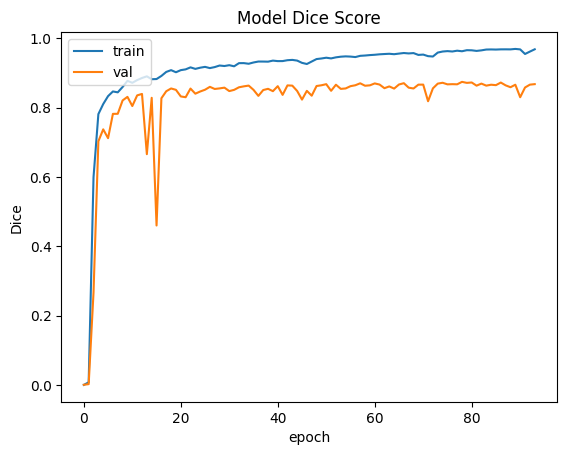

In [ ]:
# Plot the training and validation Dice scores
plt.plot(history.history["f1-score"])
plt.plot(history.history["val_f1-score"])
plt.title("Model Dice Score")
plt.ylabel("Dice")
plt.xlabel("epoch")
plt.legend(["train", "val"], loc="upper left")
plt.show()

Calculate the Dice score for each patient in the test set and average the results.

In [ ]:
def getScore(predictions, test_mask):
    intersection = np.logical_and(test_mask, predictions)
    dice_score = (np.sum(intersection) * 2) / (np.sum(predictions) + np.sum(test_mask))

    return dice_score


# Loop through each item, predict, and calculate scores

dice_scores = []

for i in range(X_test.shape[0]):
    single_item = np.expand_dims(X_test[i], axis=0)
    pred = model.predict(single_item)
    pred_t = (pred > 0.5).squeeze()  #  remove any singleton dimensions
    Y_test_single = Y_test[i]
    dice_score = getScore(pred_t, Y_test_single)

    dice_scores.append(dice_score)

# Calculate average scores

print(f"Dice for the whole test set: {round(np.average(dice_scores),3)}")

1/1 [==============================] - 0s 43ms/step
Dice for the whole test set: 0.851


Create a dataframe containing the index of the patient and the corresponding dice score

In [ ]:
model_df = build_dfs(test_indices, dice_scores)

In [ ]:
model_df

,Patient Indices,Dice
0,24,0.569697
1,6,0.907692
2,152,0.930233
3,209,0.963504
4,237,0.97006
5,199,0.972973
6,190,0.96875
7,150,0.94902
8,9,0.944238
9,113,0.925926


Create a function to plot patientwise dice scores from a dataframe.

In [ ]:
def plotDice(dataframe):

    plt.figure(figsize=(10, 20))
    spacing = 1.5  # Adjust this to increase/decrease spacing
    y_positions = np.arange(len(dataframe)-2) * spacing
    plt.barh(y_positions, dataframe["Dice"].iloc[:-2].astype(float), color="blue", edgecolor="black") # leave out the avg. and std. lines of the df
    plt.ylabel("Index")
    plt.xlabel("Dice Score")
    plt.title("Dice Scores per Index")
    plt.yticks(y_positions, dataframe["Patient Indices"].iloc[:-2])

    plt.xlim(0, 1)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.tight_layout()
    plt.show()



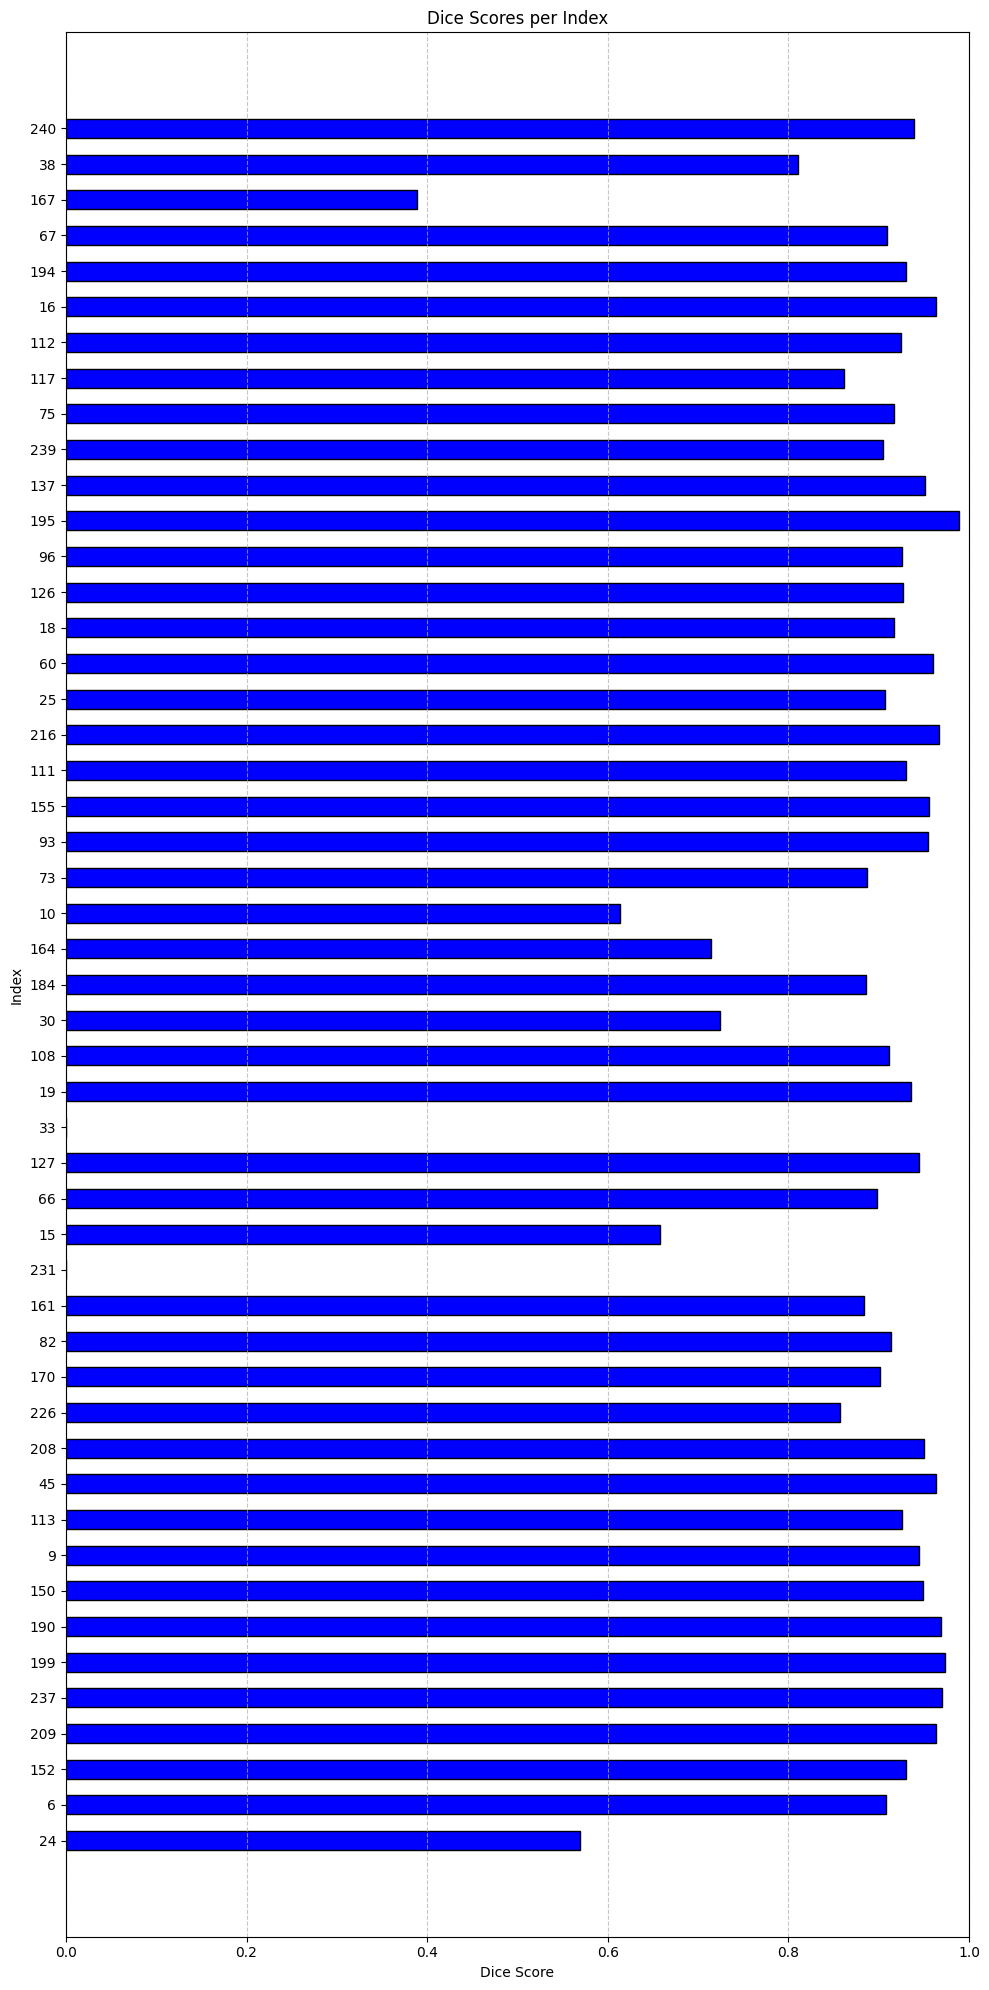

In [ ]:
plotDice(model_df)

In [ ]:
'''
Interquartile Range (IQR) is the difference between the third quartile (Q3) and the first quartile (Q1).
Inner fences: These are calculated as:

    Lower inner fence: Q1-1.5xIQRQ1-1.5xIQR
    Upper inner fence: Q3+1.5xIQRQ3+1.5xIQR
Outlier Determination: Outliers are determined based on the whiskers of the box plot.
Data points outside of the whiskers are considered outliers.

Outlier Plotting: In the plot, outliers are represented as individual "flier" points beyond the whiskers.
By default, they are plotted as small circles.
'''
def box_plotDice(dataframe):
    # Extract dice scores and exclude the Avg. and Std. rows
    dice_scores = dataframe["Dice"].iloc[:-2].astype(float)

    # Create the box plot without a notch
    plt.figure(figsize=(6, 4))
    bp = plt.boxplot(dice_scores, vert=False, widths=0.7, notch=False)

    # Overlay the mean
    mean_dice = dice_scores.mean()
    std_dice = dice_scores.std()
    plt.scatter(mean_dice, 1, color='red', marker='x', label=f'Mean: {mean_dice:.2f} ± {std_dice:.2f}', zorder=5)

    # Add the median (orange line) to the legend
    median_line = bp['medians'][0]
    median_line.set_label(f'Median: {np.median(dice_scores):.2f}')
    # Add the outlier symbol to the legend
    outlier_symbol = bp['fliers'][0]
    plt.plot([], [], 'o', color=outlier_symbol.get_color(), markerfacecolor='none', label='Outliers (beyond 1.5*IQR)')

    plt.xlabel("Dice Score")
    plt.title("Box Plot of Dice Scores")
    plt.yticks([])
    plt.xlim(0, 1)
    plt.grid(axis="x", linestyle="--", alpha=0.7)
    plt.legend(loc="upper left")
    plt.tight_layout()
    plt.show()

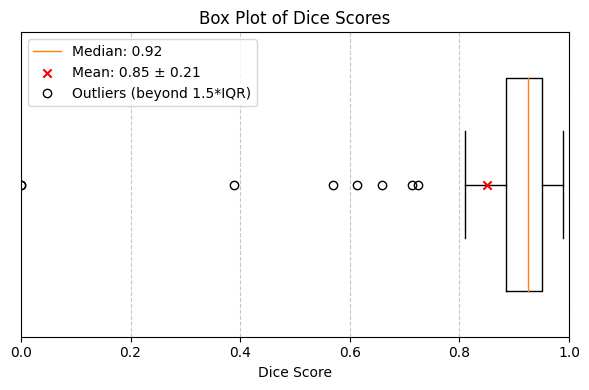

In [ ]:
box_plotDice(model_df)

In [ ]:
def plot_test_image_with_contours_multicolumn(index, X_test, Y_test, slices_per_row=2):
    """
    Plots multiple slices of a 3D test image with annotated and predicted contours in a multi-column format.

    Parameters:
    - index: Index of the test image to plot.
    - X_test: Array of test images.
    - Y_test: Array of annotated masks/lines.
    - slices_per_row: Number of slices to display per row.
    """

    # Extract the specified test image and its corresponding masks
    img = X_test[index]
    annotated_mask = Y_test[index]


    predicted_mask = model.predict(np.expand_dims(X_test[index, ...], axis=0))

    predicted_mask_t = predicted_mask > 0.5
    slice_indices = [
        i for i in range(img.shape[2]) if np.sum(annotated_mask[:, :, i]) > 0
    ]  # Get the slices where annotation exists

    num_slices = len(slice_indices)
    num_rows = int(np.ceil(num_slices / slices_per_row))

    fig = plt.figure(figsize=(15, 7 * num_rows))

    for i, idx in enumerate(slice_indices):
        plt.subplot(num_rows, slices_per_row, i + 1)  # Create a subplot for each slice

        # Display the test image slice
        plt.imshow(img[:, :, idx], cmap="gray")

        # Display the annotated contour (in green color) for the slice
        plt.contour(annotated_mask[:, :, idx], colors="b", linewidths=0.5, levels=[0.5] )

        # Display the predicted contour (in red color) for the slice
        plt.contour(
            predicted_mask_t[0,:, :, idx,0], colors="r", linewidths=0.5,
        )

        plt.title(f"Slice {idx}")
        plt.axis("off")

    plt.tight_layout()
    plt.suptitle(f'Annotated (Blue) and Predicted (Red) Contours of patient index {model_df["Patient Indices"].iloc[index]} with Dice score of {round(model_df["Dice"].iloc[index],2)}', y=1.02)
    plt.show()




1/1 [==============================] - 0s 45ms/step


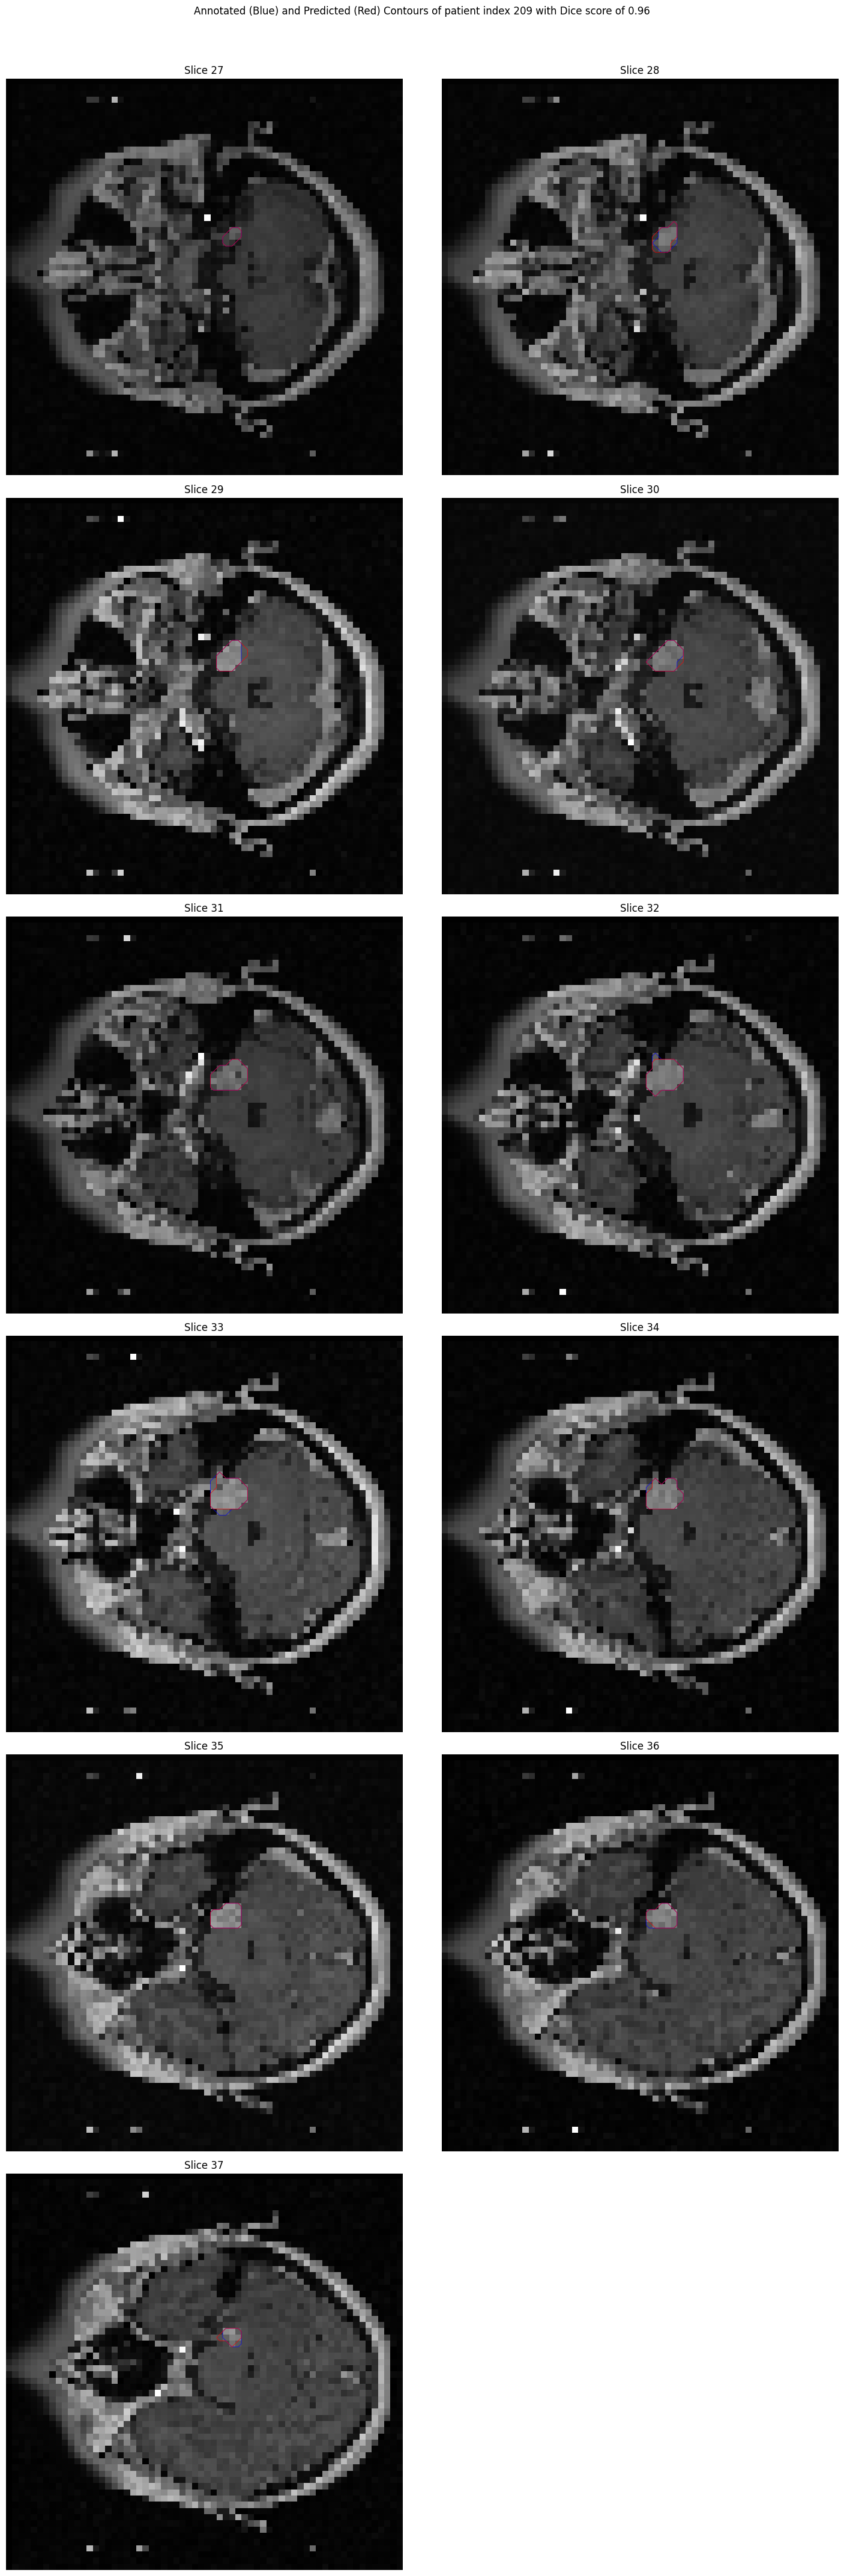

In [ ]:
plot_test_image_with_contours_multicolumn(3, X_test, Y_test)
